# HW 1, Part 2
## By James Camacho

Our goal is to implement a expectation-maximization clustering algorithm. We will make use of the following variables:

```
Xs      N x D (N vertices of dimension D)
p       K x D (K clusters of dimension D)
mix_p   K x 1 (chance of being in each cluster, aka pi)
eta     N x K (eta[i, k] = eta(z_k^i))
```

In [1]:
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
# 2.1.1
def eta(Xs, p, mix_p):
    """
    Returns eta.
    """
    h = Xs @ np.log(p).T + (1-Xs) @ np.log(1-p).T
    h += np.log(mix_p)[None,:]
    h -= np.mean(h) # Normalizes h so no overflow errors.
    h = np.exp(h)
    h /= np.sum(h,axis=1)[:,None]
    return h

# 2.1.2
def maximize(eta, Xs, alpha1=1e-8, alpha2=1e-8):
    """
    Returns maximum values for p, mix_p.
    alpha1 and alpha2 are smoothing parameters.
    """
    p_num = eta.T @ Xs + alpha1
    p_denom = np.sum(eta, axis=0)[:,None] + alpha1 * Xs.shape[-1] # i.e. alpha1 * D
    
    mix_p_num = np.sum(eta, axis=0) + alpha2
    mix_p_denom = np.sum(eta) + alpha2 * eta.shape[-1] # i.e. alpha2 * K

    return p_num / p_denom, mix_p_num / mix_p_denom


# 2.1.3
def cluster(Xs, K, iters=20):
    """
    Determines K clusters for the Xs.
    """
    N, D = Xs.shape
    p = np.random.random((D,K))
    p /= np.sqrt(np.sum(p**2, axis=0))[None,:]
    p = p.T
    mix_p = np.ones(K) / K  
    for i in tqdm(range(iters), desc="Clustering..."):
        h = eta(Xs, p, mix_p)
        p, mix_p = maximize(h, Xs)

    return p, mix_p

# 2.1.3
def label(Xs, p, mix_p):
    """
    Finds which cluster each X belongs to.
    """
    h = eta(Xs, p, mix_p)
    return np.argmax(h, axis=1)

def group(data, labels):
    """
    Groups the Xs by the labels.
    """
    groups = [[] for i in range(max(labels) + 1)]
    for i, l in enumerate(labels):
        groups[l].append(data[i])
    return groups

Okay great! We got the algorithm all sorted out. Let's try it with 500 images from the MNIST dataset:

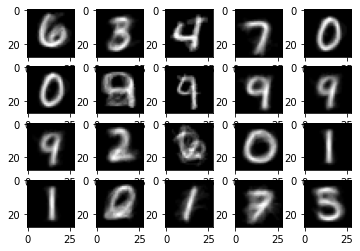

In [3]:
IMAGES = 500
K = 20 # Number of clusters.

# Prepare image data
if IMAGES:
    mnist = next(read_csv("mnist.csv", chunksize=IMAGES))
else:
    mnist = read_csv("mnist.csv")

digits = mnist["label"].to_numpy() # For use later.
mnist.drop("label", 1, inplace=True)

# Can round for binary x values, but since we have grayscale we might as well use it.
Xs = mnist.to_numpy()/255

# Find the p, mix_p for the clusters.
p, mix_p = cluster(Xs, K)

# Graph
rows = int(K**0.5)
cols = (K + rows - 1) // rows
fig, axes = plt.subplots(rows, cols)
for i in range(rows):
    for j in range(cols):
        im = np.reshape(p[i*rows + j], (28, 28))
        ax = axes[i, j] if rows > 1 else axes[j]
        ax.imshow(im, cmap='gray')
plt.show()

In [4]:
labels = label(Xs, p, mix_p)
groups = group(digits, labels)

cluster_digits = np.array([len(set(g)) for g in groups])

print(f"Digits per cluster:\n{cluster_digits}")
print(f"Mean digits per cluster: {np.mean(cluster_digits)}")
print(f"Single-digit clusters: {np.where(cluster_digits == 1)[0]}")

Digits per cluster:
[1 7 2 3 1 2 3 4 4 2 4 3 3 4 8 6 5 6 3 2]
Mean digits per cluster: 3.65
Single-digit clusters: [0 4]


Most clusters have more than one unique digit, but some do pick out exactly one digit.